In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from astropy.table import Table 

%pylab inline --no-import-all

matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=18              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'

colours = mpl.rcParams['axes.color_cycle'] 

import pysynphot as S

import specutils
from astropy.io import fits as pyfits
from astropy.wcs import WCS
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter1d


Populating the interactive namespace from numpy and matplotlib


/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/m

## We are going to use the pysynphot package to access PHOENIX stellar atmosphere models (http://www.stsci.edu/hst/observatory/crds/SIfileInfo/pysynphottables/index_phoenix_models_html) to simulate a spectral library.

In [2]:
# use Phoenix models for Teff, metallicity (dex), log g in that order 

# alpha cen A: Teff = 5790, Z = 0.20, log g = 4.30
acenA = S.Icat('phoenix',5790,0.2,4.30)

# alpha cen B: Teff = 5260, Z = 0.23, log g = 4.37
acenB = S.Icat('phoenix',5260,0.23,4.37)


In [6]:
nwavels = 6000
wavels = np.linspace(3000,9000,nwavels)
specA = acenA.sample(wavels)
specB = acenB.sample(wavels)


Text(0.5,1.01,u'Test Generating Spectra - $\\alpha$ Cen')

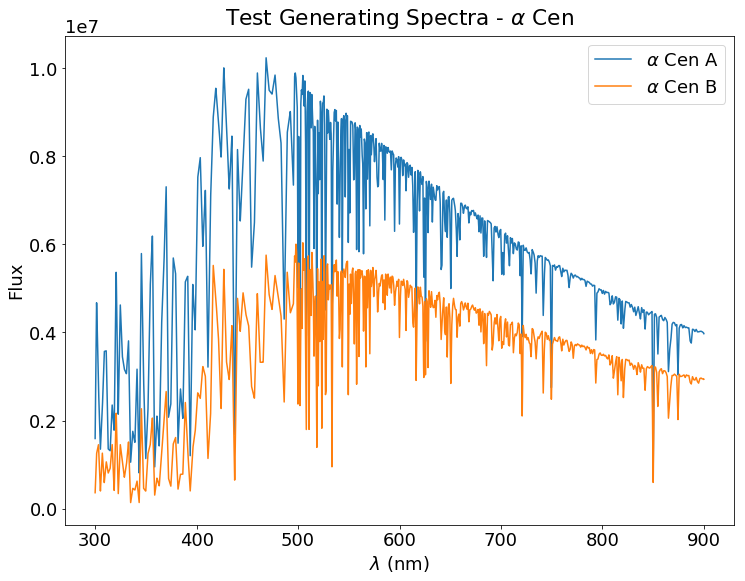

In [152]:
plt.plot(wavels/10.,specA,label=r'$\alpha$ Cen A')
plt.plot(wavels/10.,specB,label=r'$\alpha$ Cen B')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Flux')
plt.legend()
plt.title(r'Test Generating Spectra - $\alpha$ Cen',y=1.01)


## Now we generate a grid of spectral models at different temperatures and metallicities.

In [112]:
nspectra = 1000
tmin, tmax = 4000,6000
zmin, zmax = -1.,0.5
loggmin,loggmax = 0,6


temps = (tmax-tmin)*np.random.rand(nspectra)+tmin
zs = (zmax-zmin)*np.random.rand(nspectra)+zmin
loggs = (loggmax-loggmin)*np.random.rand(nspectra)+loggmin # placeholder - we fix log g for the moment

spectra = np.zeros((nwavels,nspectra))

In [138]:
%%time
for j in range(nspectra):
    model = S.Icat('phoenix',temps[j],zs[j],4.37)
    spectra[:,j] = model.sample(wavels)

CPU times: user 2min 14s, sys: 4.04 s, total: 2min 18s
Wall time: 3min


In [139]:
from sklearn.preprocessing import normalize

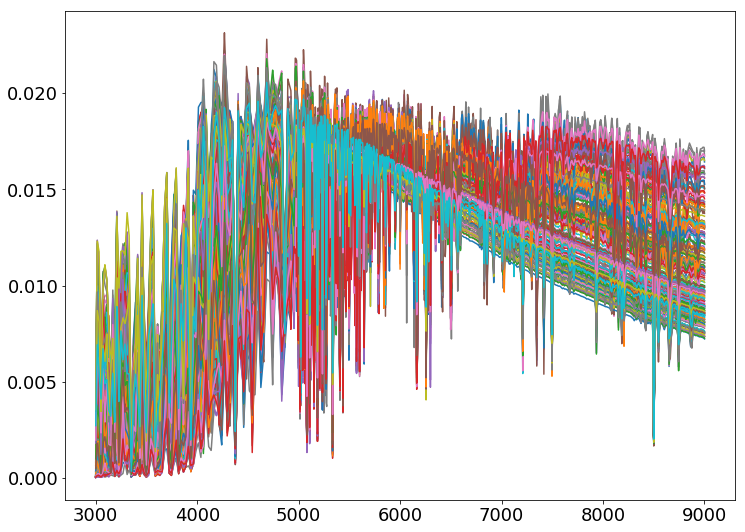

In [140]:
spectral = normalize(spectra,axis=0) # best to normalize for good machine learning performance
for j in range(nspectra/5):
    plt.plot(wavels,spectral[:,j*5])

## Now let's try learning an embedding of this dataset

In [141]:
from sklearn import manifold


### Apply and save all the methods for manifold learning in scikit-learn

In [149]:
%%time
n_neighbors = 20
n_components = 2
X = spectral.T

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE','Isomap','MDS','Spectral Embedding', 't-SNE']
ys = []
for i, method in enumerate(methods):
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform((X))
    ys.append(Y)

Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
ys.append(Y)

mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
ys.append(Y)

se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
ys.append(Y)

tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
ys.append(Y)

CPU times: user 1min 29s, sys: 8.32 s, total: 1min 37s
Wall time: 1min 6s


### Plot effective temperature as a colourmap

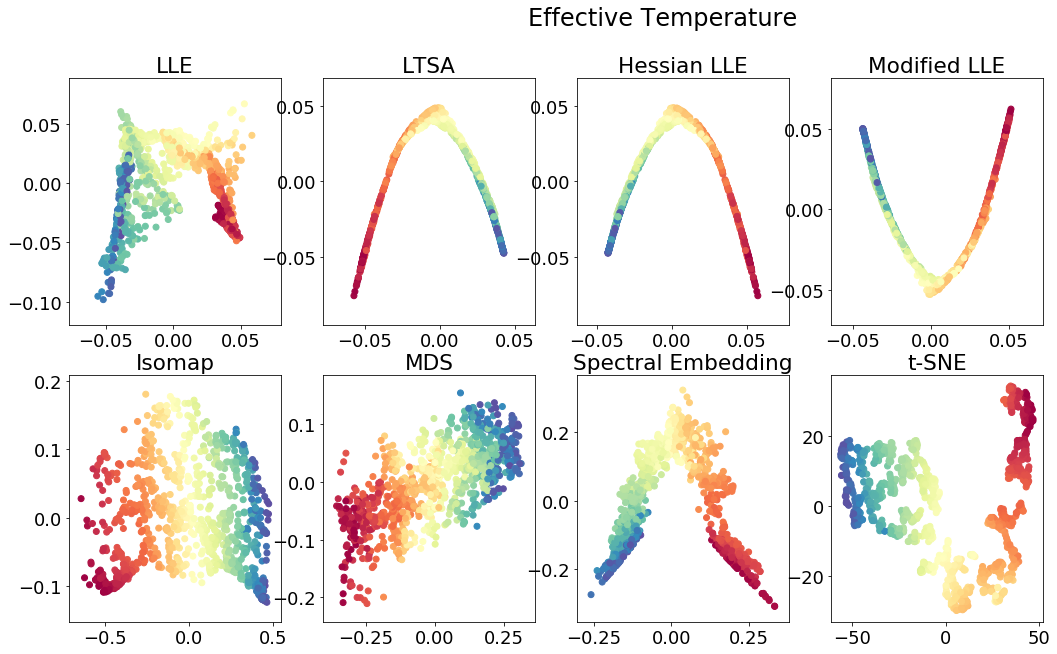

In [150]:
fig = plt.figure(figsize=(22, 10))
plt.suptitle("Effective Temperature", fontsize=24)

jj = np.arange(len(labels))
jj[4:] += 1
for i, label in enumerate(labels):
    Y = ys[i]
    ax = fig.add_subplot(251 + jj[i])
    plt.scatter(Y[:, 0], Y[:, 1], c=temps, cmap=plt.cm.Spectral)
    plt.axis('tight')
    plt.title(label)


### Plot metallicity as a colourmap

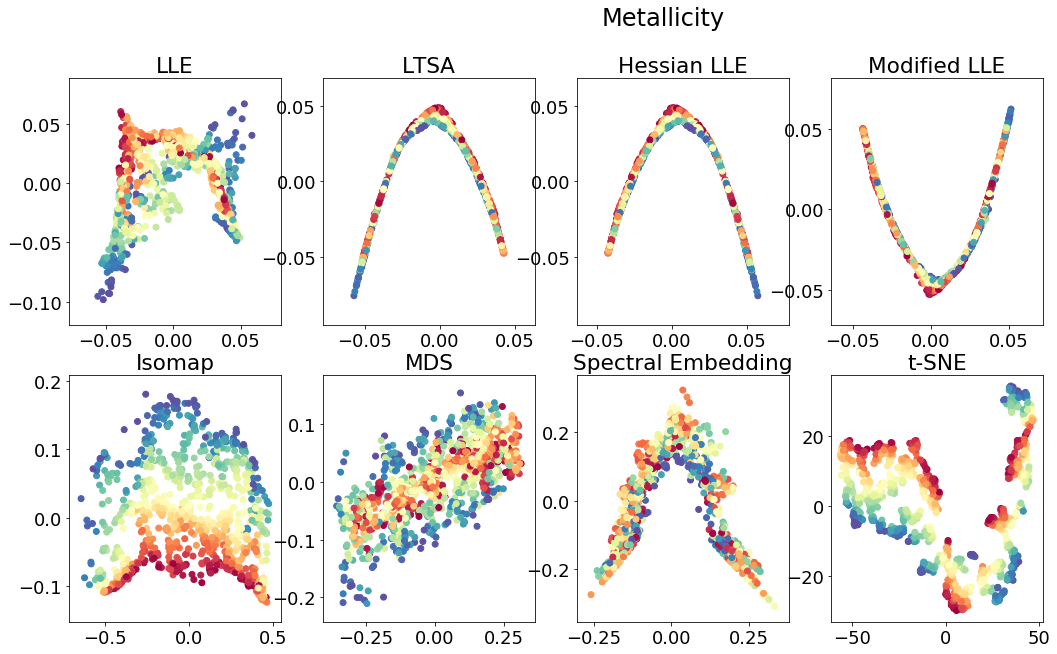

In [151]:
fig = plt.figure(figsize=(22, 10))
plt.suptitle("Metallicity", fontsize=24)

jj = np.arange(len(labels))
jj[4:] += 1
for i, label in enumerate(labels):
    Y = ys[i]
    ax = fig.add_subplot(251 + jj[i])
    plt.scatter(Y[:, 0], Y[:, 1], c=zs, cmap=plt.cm.Spectral)
    plt.axis('tight')
    plt.title(label)


### As we see, the Isomap and t-SNE methods both correctly separate temperature and metallicity as the orthogonal parameters that best describe this dataset.